In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-12-17 22:04:58.008253: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 22:04:58.014982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 22:04:58.022829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 22:04:58.025291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 22:04:58.031197: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1734498301.393463  282816 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734498301.416702  282816 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734498301.418417  282816 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734498301.422033  282816 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [27]:
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    inputs = np.load("all_inputs_3.npy")

In [28]:
inputs.shape

(3467, 1024, 1024, 1)

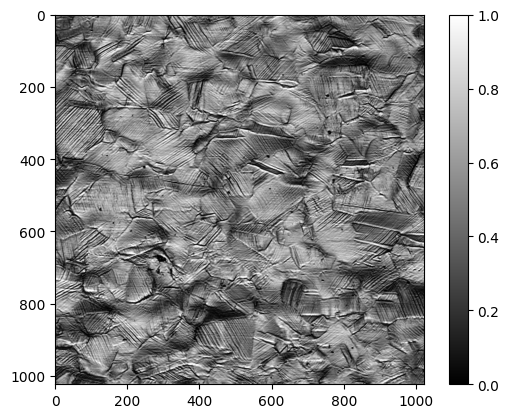

In [29]:
plt.imshow(inputs[0],cmap='grey')
plt.colorbar()

In [30]:
batchsize = 32

with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    targets = np.load("all_targets_3.npy")
    # train test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(inputs, targets, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

with tf.device("/CPU:0") :
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
with tf.device("/GPU:0") :
    train_dataset = train_dataset.shuffle(buffer_size=200).batch(batchsize)
    val_dataset = val_dataset.shuffle(buffer_size=200).batch(batchsize)

In [31]:
inputs.shape

(3467, 1024, 1024, 1)

In [38]:
conv_dim = 16
ff_dim = 32
k_dim = 3
pool_dim = 5
drop_rate = 0.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(1024, 1024, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 1016, 1016, 16) │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1016, 1016, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1016, 1016, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 203, 203, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 203, 203, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 195, 195, 16)   │        20,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 195, 195, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 195, 195, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 39, 39, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 39, 39, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 31, 16)     │        20,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 31, 31, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 6, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,505 (240.25 KB)

 Trainable params: 61,409 (239.88 KB)

 Non-trainable params: 96 (384.00 B)

In [39]:
#model.compile(optimizer=Adam(learning_rate=1e-4),
#model.compile(optimizer=Adam(learning_rate=1e-2),
#model.compile(optimizer=Adam(learning_rate=1e-5),
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [10]:
1e-5==0.00001

True

In [40]:
early_stopping = EarlyStopping(
                        monitor="val_accuracy", 
                        patience=20,  # Stop if no improvement for 5 epochs
                        mode="max", 
                        restore_best_weights=True  # Automatically restores the best model weights
                        )

optim = model.fit(train_dataset,
                  validation_data=val_dataset, 
                  epochs=400, 
                  callbacks=[early_stopping])

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4671 - loss: 0.7446

E0000 00:00:1734538526.314951  282993 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734538526.400975  282993 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734538527.443081  282993 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734538527.526677  282993 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.4673 - loss: 0.7444 - val_accuracy: 0.5441 - val_loss: 0.6904
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5338 - loss: 0.6962 - val_accuracy: 0.5405 - val_loss: 0.6909
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5506 - loss: 0.6825 - val_accuracy: 0.4559 - val_loss: 0.7166
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5644 - loss: 0.6728 - val_accuracy: 0.4559 - val_loss: 0.8082
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5961 - loss: 0.6613 - val_accuracy: 0.4559 - val_loss: 0.9527
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6151 - loss: 0.6513 - val_accuracy: 0.4559 - val_loss: 1.0126
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6291 - loss: 0.6380 - val_accuracy: 0.4559 - val_loss: 0.9531
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6646 - loss: 0.6166 - val_accuracy: 0.4559 - val

In [41]:
"max val accuracy: {0}, min val loss: {1}".format(max(optim.history['val_accuracy']),min(optim.history['val_loss']))

'max val accuracy: 0.9171171188354492, min val loss: 0.20007352530956268'

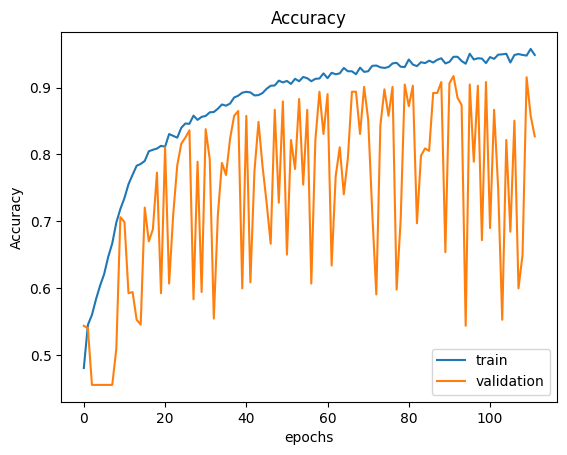

In [42]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.show()

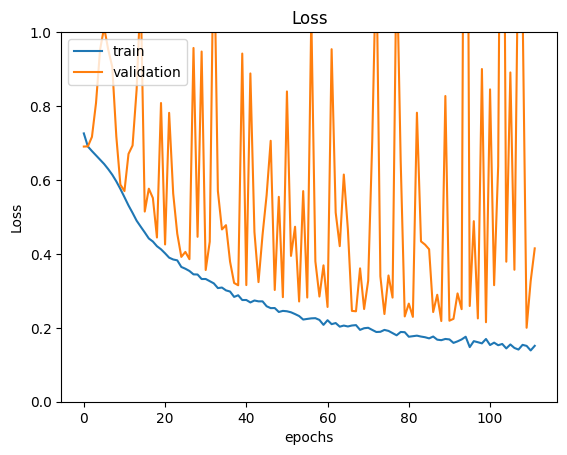

In [43]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.ylim(0,1)
plt.show()

In [44]:
test_loss, test_acc = model.evaluate(X_test, y_test)

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9114 - loss: 0.2132

E0000 00:00:1734539324.223464  282994 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734539324.309176  282994 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9112 - loss: 0.2155


In [45]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.22423337399959564, Test accuracy: 0.9121037721633911'

In [16]:
# Predict the values from the testing dataset
Y_pred_probs = best_model.predict(X_test)
Y_pred = np.array(Y_pred_probs>=.5)
# compute the confusion matrix
#confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred) 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Text(0, 0.5, 'freq')

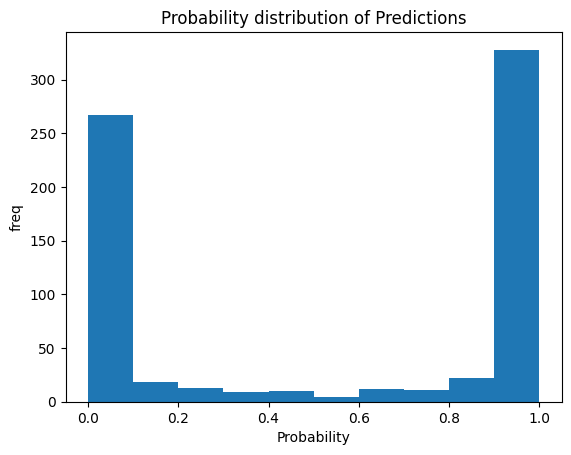

In [17]:
plt.hist(Y_pred_probs.flatten())
plt.title('Probability distribution of Predictions')
plt.xlabel('Probability')
plt.ylabel('freq')

Text(0, 0.5, 'freq')

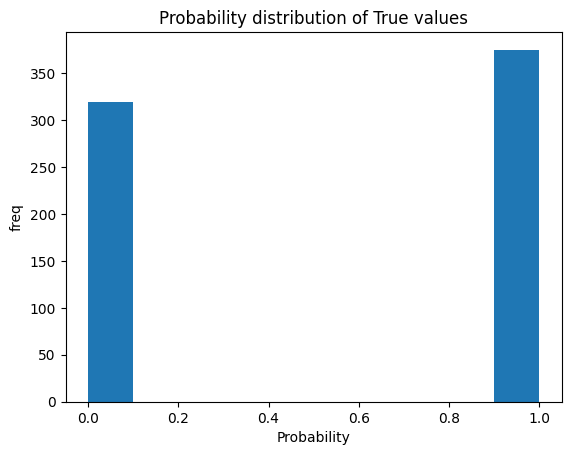

In [18]:
plt.hist(y_test)
plt.title('Probability distribution of True values')
plt.xlabel('Probability')
plt.ylabel('freq')

In [19]:
sum(y_test)

375.0

In [20]:
Y_pred = Y_pred.astype(float).flatten()

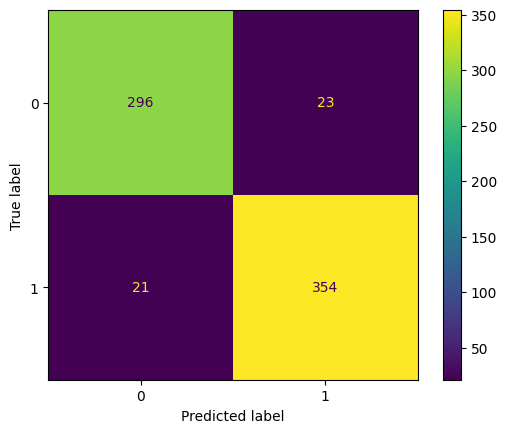

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, Y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [17]:
TP=152
TN=175
FP=13
FN=1

In [18]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(recall,precision)

0.9934640522875817 0.9212121212121213


In [19]:
(TP+TN)/(TP+TN+FP+FN)

0.9589442815249267

In [24]:
sk.metrics.precision_score(y_test, Y_pred)

0.9389920424403183

In [25]:
sk.metrics.recall_score(y_test, Y_pred)

0.944